In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from scipy.ndimage.filters import convolve

# add src to path
sys.path.append('../..')
from utils.db_helper import get_image_data

In [2]:
SOURCE_DIR_V1 = "C:/database/StyleGanv1"
SOURCE_DIR_V2 = "C:/database/StyleGanv2"
SOURCE_DIR_FFHQ = "C:/database/FFHQ"

In [3]:
ffhq_datagen = get_image_data(SOURCE_DIR_FFHQ, type = 'int')

In [4]:
def calculate_difference_image(np_img: np.ndarray)-> np.ndarray:
    """
    np_img must be int not float
    """
    np_filter = np.array((1,-1)).reshape(1,2)
    np_img = np_img.astype(np.int16)
    np_diff_img = np.empty(np_img.shape, dtype=np.int16)
    if len(np_img.shape) == 3:
        for i in range(np_img.shape[-1]):
            np_diff_img[:,:,i] = convolve(np_img[:,:,i], np_filter)
    elif len(np_img.shape) == 2:
        np_diff_img = convolve(np_img, np_filter)
    else:
        raise ValueError('Bad shape of the image')
    return np_diff_img

In [53]:
def avg_hist_from_diff_img(src_path: str, max_number_of_images = 10, bins=511)-> np.ndarray:
    print("Loading dataset...")
    hist_range = (-255,256)  #ToDo automatic generation based on bins
    dataset_gen = get_image_data(src_path, type='int')
    print("Processing database...")
    number_of_images = 0
    np_avg_hist = np.zeros((bins,), dtype=np.float64)
    for img in dataset_gen:
        diff_img = calculate_difference_image(img)
        hist, _ = np.histogram(diff_img, density=True, bins=bins, range=hist_range)
        np_avg_hist += hist
        number_of_images += 1
        if np_avg_hist.max() > 0.95*np.finfo(np_avg_hist.dtype).max:
            raise ValueError("Dataset to large")
            break
        elif number_of_images == max_number_of_images:
            print("Finish calcluating avg histogram")
            break
    return np_avg_hist / number_of_images, range(hist_range[0], hist_range[1])


In [68]:
np_avg_hist, bins = avg_hist_from_diff_img(SOURCE_DIR_FFHQ, max_number_of_images=500)

Loading dataset...
Processing database...
len: 3000
Finish calcluating avg histogram


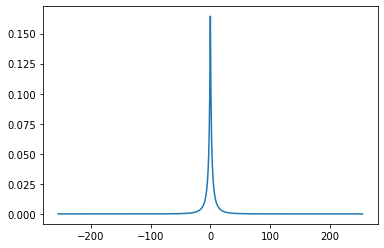

In [69]:
fig, ax = plt.subplots()
ax.plot(list(bins), np_avg_hist)